This is an interesting example that came up in conversation with another engineer related to a construction project happening at an existing facility. Imagine construction involving scaffolding and workers at an elevation that potentially puts them within the plume of an existing stack -- say from an adjacent boiler. If the facility is still operating while this construction work happens then it is possible that workers will be exposed to combustion products in excess of the occupational exposure limits. The operating boiler does not have to be all that close by for the plume -- which is very visible this time of year in the cold weather -- to envelope a similarly tall set of scaffolding.

So, how would one determine whether or not the operating stack presents a hazard to the workers? In practice by hiring a consultant to do detailed modelling, because safety issues like this are not the time to pencil-whip some number. But we may want to come up with a rough estimate regardless, and for that a Gaussian dispersion model of the stack can be a useful first start.

::: {#fig-plume}
![](Gaussian_Plume.png)

The problem domain, a stack with a Gaussian plume (<a href="https://commons.wikimedia.org/wiki/File:Gaussian_Plume.png">Mbeychok</a>, <a href="http://creativecommons.org/licenses/by-sa/3.0/">CC BY-SA 3.0</a>, via Wikimedia Commons).
:::

## The Scenario

Suppose a natural gas boiler with a rated capacity, $W$, of 300GJ/h, stack height, $h_s$, of 10m and diameter, $D_s$ of 2m, and an exit temperature of 450K.

In this case we are interested in the carbon monoxide concentrations at a work platform at the same height as the stack and 100m away, we also would like to know the concentration for a worker at ground level. I am approximately 2m tall let's suppose the relevant height is 2m (for anyone shorter than that the concentration should be lower and thus this is conservative).

Additionally I am assuming ambient conditions of 25°C and 1atm

In [1]:
#| output: false
using Unitful

W = uconvert(u"GJ/s", 300u"GJ/hr")
hₛ = 10u"m"   # stack height
Dₛ = 2u"m"    # stack diameter
Tₛ = 450u"K"  # stack exit temperature

h₁ = hₛ      # height of platform, m
x₁ = 100u"m" # distance to platform, m

pₐ = 101.325u"kPa" # ambient pressure, 1atm
Tₐ = 298.15u"K"    # ambient temperature, 25°C

298.15 K

Prior to any dispersion modelling, the following parameters need to be collected:

+ the mass emission rate of the species, carbon monoxide, in kg/s
+ the concentration of interest, in this case the occupational exposure limit of carbon monoxide in kg/m3
+ the wind speed and atmospheric stability
+ the *effective* stack height, in m

### Mass Emission Rate

The EPA has tabulated *emission factors* for most combustion products in EPA AP-42 and for a natural gas boiler it is *84 lb/10^6 SCF*[@epa-1995a Table 1.4-1. The emission factor is relative to the volume of natural gas consumed not the volume of stack gas emitted] with a reference higher heating value of *1020 MMBTU/10^6 SCF*.


If we suppose the boiler is operating at max rates then the mass emission rate is

$$ Q = { W \cdot EF \over HV}  $$

Where *EF* is the emission factor and *HV* the higher heating value.

In [2]:
HV = uconvert(u"GJ/m^3", 1020u"btu/ft^3")
EF = uconvert(u"kg/m^3", 84*1e-6u"lb/ft^3")

Q = EF * W / HV # mass emission rate in kg/s

0.002950437713234783 kg s^-1

This gives a mass flow rate of carbon monoxide in the plume, but we will also need some sense of how large the plume is in general, i.e. what is the volumetric flow rate of stack gas exiting the stack?


### Volumetric Flow Rate of Flue Gas

There are several ways the volumetric flow rate of flue gas could be estimated. One simple method is to use EPA Method 19[@epa-2017] with the equation

$$ V_s^o = F_w { 20.9 \over 20.9 \left( 1 - B_{wa} \right) - \%O_{2w} } \cdot W$$

Where $V_s^o$ is the volumetric flow of flue gas at *standard conditions*, $B_{wa}$ the moisture fraction of ambient air, $\%O_{2w}$ the percentage of oxygen on a wet basis, and the parameter $F_w$ captures the differences in combustion stoichiometry for different fuels and is tabulated. Alternatively one could work out the volume of stack gas from the stoichiometry of combustion, this is just a shortcut.

+ the default value for $B_{wa} = 0.027$
+ $\%O_{2w}$ usually ranges from 2-6% and for this case I am assuming $\%O_{2w} = 4$
+ from Method 19 for natural gas, $F_w = 2.85 \times 10^{-7} \mathrm{sm^3 \over J}$



In [3]:
Fw = 2.85e-7u"m^3/J"
pct_O2 = 4
Bwa = 0.027

Vₛᵒ = Fw * (20.9 / (20.9*(1-Bwa) - pct_O2)) * W

Vₛᵒ = upreferred(Vₛᵒ)

30.385903267077627 m^3 s^-1

The actual volumetric flow rate can be calculated assuming the ideal gas law

$$ { p^o V_s^o \over T^o } = { p_a V_s \over T_s } $$

$$ V_s = { T_s \over T^o } { p^o \over p_a } V_s^o $$

Where the standard conditions of Method 19 are $T^o = 20 \mathrm{C}$ and $p^o = 760 \mathrm{mm Hg}$

In [4]:
# Unitful doesn't know what "mm Hg" is
@unit mmHg "mm Hg" MillimetersMercury 133.322387415u"Pa" false 

Tᵒ = uconvert(u"K", 20u"°C")
pᵒ = uconvert(u"kPa", 760mmHg)

Vₛ = (Tₛ / Tᵒ) * (pᵒ / pₐ) * Vₛᵒ

46.6438970432218 m^3 s^-1

### The Concentration of Interest

This analysis is fundamentally about identifying whether a worker on the work platform would experience flue gases in excess of some concentration of interest. In this case I am supposing the Occupational Exposure Limit (OEL) for carbon monoxide alone because it is simple. In practice, since flue gas is a mixture of many substances that each have an associated OEL, one would have to look at the cumulative impact of all of these substances instead of treating them all individually[^ccohs]

[^ccohs]: For example [CCOHS](https://www.ccohs.ca/oshanswers/hsprograms/occ_hygiene/occ_exposure_limits.html) recommends calculating the sum $$ \sum_i {C_i \over T_i } $$ for each substance *i* where *C* is the observed concentration and *T* is the threshold, and this sum should be less than one.

For carbon monoxide there are three concentrations of interest worth considering[^niosh]

[^niosh]: From the [NIOSH Handbook](https://www.cdc.gov/niosh/npg/npgd0105.html), using the conversion 1.15 mg/m^3 per ppm

+ the Time Weighted Average (TWA) concentration which represents the limit for workers in that environment for a standard shift and 40 hours per week
+ the Ceiling concentration which is the level that the concentration cannot exceed
+ the Immediately Dangerous to Life and Health (IDLH) limit which is a concentration that could either kill a worker outright or render them incapable of saving themselves


| Limit   | ppm                 | mg/m^3                 |
|---------|---------------------|------------------------|
| TWA     | 35                  | 40                     |
| Ceiling | 200                 | 229                    |
| IDLH    | 1200                | 1380                   |



In [5]:
TWA = uconvert(u"kg/m^3", 40u"mg/m^3")
Ceil = uconvert(u"kg/m^3", 229u"mg/m^3")
IDLH = uconvert(u"kg/m^3", 1380u"mg/m^3");

We can check if the stack gas concentration at the exit exceeds the TWA. If it does not exceed the TWA then there is no reason to proceed with the calculations as a worker could work *in the stack* and not exceed the limits and they certainly would not exceed the limits after the plume mixed with ambient air.

In [6]:
uconvert(u"mg/m^3", Q/Vₛᵒ)

97.0988977125952 mg m^-3

In [7]:
Q/Vₛᵒ > TWA

true

The concentration in the flue gas is above the limit for long term work exposure but below the ceiling. At this point we are justified in continuing on to estimate the concentration at the work platform.

## Meteorological Conditions

The ambient conditions impact the release in some obvious ways and in some non-obvious ways. Obviously the wind speed impacts how far the plume is moved, through advection. Somewhat non-obviously the ambient conditions also govern how high the plume will rise due to buoyancy as well as the extent of mixing as the plume moves through the air.

Suppose a wind speed of 1.5m/s at the stack height, just arbitrarily.

In [8]:
uₛ = 1.5u"m/s"

1.5 m s^-1

### Atmospheric Stability

The atmospheric stability relates to the vertical mixing of the air due to a temperature gradient, during the day air temperature decreases with elevation and this temperature gradient induces a vertical flow that leads to vertical mixing.

::: {#fig-stability}
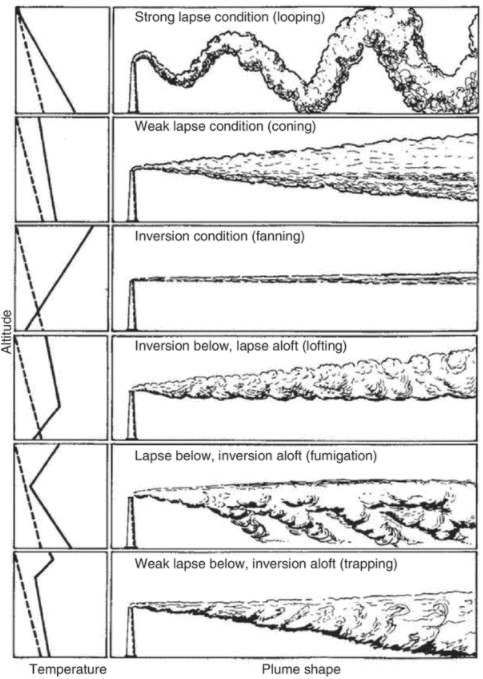

The effect of atmospheric stability on plume dispersion.
:::

This is captured by the atmospheric stability parameter $s$ which is given by[@epa-1995b page 1-9]

$$ s = \frac{g}{T_a} { \partial \theta \over \partial z } $$

Where $\partial \theta \over \partial z$ is the lapse rate in K/m

The "worst case" is the case with the least mixing and corresponds to a class F [Pasquill stability](https://en.wikipedia.org/wiki/Outline_of_air_pollution_dispersion#Characterization_of_atmospheric_turbulence), i.e. very stable, which has a corresponding default lapse rate of ${ \partial \theta \over \partial z } = 0.035 K/m$.[@epa-1995b page 1-9]

::: {.callout-warning} 
## Addendum

This isn't entirely true. For neutrally buoyant plumes released at ground level, or in this case level with the elevated work platform, class F is likely the worst case. For buoyant plumes released at elevation the minimal vertical dispersion with stable atmospheres means the bulk of the plume will rise and be dispersed far above the ground and another class and wind speed should be considered. See *Guidelines for Use of Vapour Cloud Dispersion Models*, 2nd ed. section 5.8 for more details
:::

In [9]:
# acceleration due to gravity
g = 9.80616u"m/s^2"

# default lapse rate for class F
Γ = 0.035u"K/m"

# stability parameter
s = (g/Tₐ) * Γ

0.0011511507630387393 s^-2

### Effective Stack Height

The plume rising out of the stack will rise higher than the stack height due to buoyancy -- in this case because the stack gas is at a higher temperature than the ambient air -- and because the stack gas is ejected with some kinetic energy. What follows is essentially a simplified version of the Brigg's model for plume rise for stable plumes.

As a first check, verify that stack down wash will not be relevant. For low momentum releases the effective stack height of the plume is reduced by vortices shed downwind of the stack that pull the plume downwards. This is only really relevant when $v_s \lt 1.5 u$

Where $v_s$ is the stack exit velocity and is calculated from the volumetric flow as

$$ v_s = { V_s \over A_s} = { V_s \over \frac{\pi}{4} D^2 } $$ 

In [10]:
vₛ = Vₛ / ((π/4)*Dₛ^2)

vₛ > 1.5uₛ

true

The following assumes a *stable* plume rise, recall that Pasquill stability class F corresponds to very stable conditions.

The first question that must be answered is whether or not the plume rise is dominated by buoyancy or by momentum. For buoyant plume rise to dominate the actual temperature difference -- the difference between the stack exit temperature and the ambient temperature -- must be greater than a critical temperature difference[@epa-1995b page 1-9]

$$ T_s - T_a = \Delta T \gt \left( \Delta T \right)_c = 0.019582 T_s v_s \sqrt{s} $$

In [11]:
ΔTc = 0.019582u"m^-1*s^2" * Tₛ * vₛ * √(s)

(Tₛ - Tₐ) > ΔTc

true

In this case buoyant plume rise is dominant, and the stable plume rise equation is[@epa-1995b page 1-9]

$$ \Delta h = 2.6 \left( F_b \over u_s s \right)^{1/3} $$

where $\Delta h$ is the increase in effective stack height due to plume rise, and $F_b$ is the buoyancy flux parameter[@epa-1995b page 1-6]

$$ F_b = g v_s D_s^2 { \left( T_s - T_a \right) \over 4 T_s } $$

Plume rise is not instantaneous and the distance to the final rise, $x_f$ is given by[@epa-1995b page 1-9]

$$ x_f = 2.0715 {u_s \over \sqrt{s} } $$

with any distance closer to the source than $x_f$ experiencing a lesser plume rise, given by[@epa-1995b page 1-10]

$$ \Delta h = 1.60 \left( F_b x^2 \over u_s^3 \right)^{1/3} $$

this can be put together into a function that calculates $\Delta h$ as a function of distance *x*

In [12]:
Fb = g * vₛ * Dₛ^2 * (Tₛ - Tₐ) / (4Tₛ)

49.1299376393856 m^4 s^-3

In [13]:
xf = 2.0715*uₛ/√(s)

91.58199372993636 m

In [14]:
function Δh(x)
    xf = 2.0715*uₛ/√(s)
    
    if x < xf
        return 1.60*(Fb*x^2/uₛ^3)^(1/3)
    else
        return 2.6*(Fb/(uₛ*s))^(1/3)
    end
    
end;

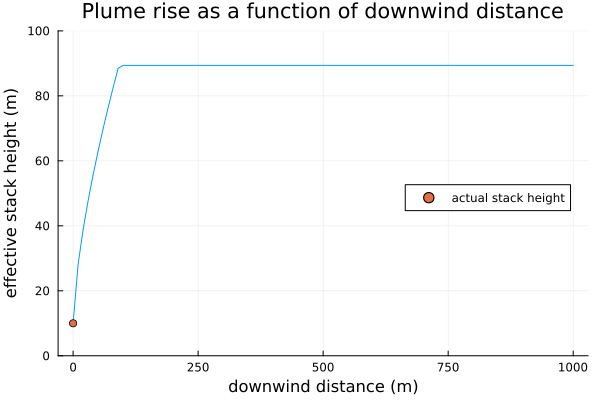

In [15]:
#| echo: false
#| label: fig-plume-height
#| fig-cap: "Plume rise as a function of downwind distance."

using Plots: @layout, plot, plot!, contour

let

function plt_heights(x)
    # in general numbers with units don't play nicely with plots
    height = Δh(x*u"m") + hₛ
    return ustrip(height)
end

xs = 0:10:1000
hs = plt_heights.(xs)

plot(xs, hs, ylims=(0,100), lab=false, 
    title= "Plume rise as a function of downwind distance",
    xlabel="downwind distance (m)", ylabel="effective stack height (m)")
plot!([0], [ustrip(hₛ)], seriestype=:scatter, lab="actual stack height", leg= :right)

end

Plume rise is impacted by the wind speed at the stack height, as the following plot shows, but with several large caveats. For one the model for plume rise given is not defined at no wind speed and for very low wind speeds the value should be treated with suspicion. Similarly for very large wind speeds the assumption of stable rise is likely quite invalid.

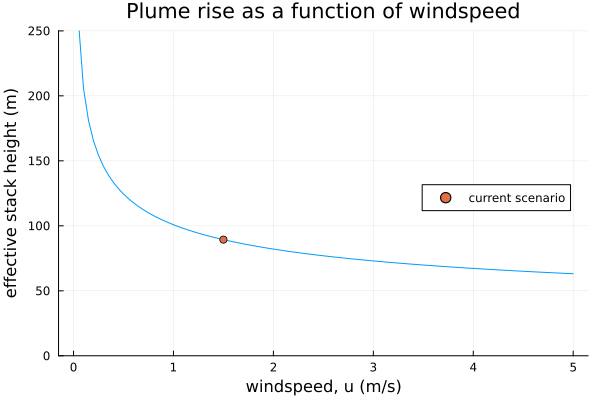

In [16]:
#| echo: false
#| label: fig-plume-wind
#| fig-cap: "Plume rise as a function of windspeed."
let

stack_height = ustrip(hₛ)
f_buoy = ustrip(Fb)
stab = ustrip(s)

plt_hf(u) = 2.6*(f_buoy/(u*stab))^(1/3) + stack_height

us = 0:0.05:5
hfs = plt_hf.(us)

plot(us, hfs, ylims=(0,250), lab=false, 
    title= "Plume rise as a function of windspeed",
    xlabel="windspeed, u (m/s)", ylabel="effective stack height (m)")
plot!([ustrip(uₛ)], [plt_hf(ustrip(uₛ))], seriestype=:scatter, lab="current scenario", leg= :right)

end

## Gaussian Dispersion Model

As the plume is carried downwind it will mix with the ambient air and the pollutant, carbon monoxide, will be dispersed. A simple model of this is a Gaussian dispersion model, the derivation for which is sketched out as follows.

### A Differential Mass Balance

Starting with a coordinate system centred at the top of the stack, emitting a mass flow of *Q* kg/s, which is assumed to be released from a point, the [advection-diffusion equation](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation) for mass can be written as

$$ {\partial C \over \partial t} = - \nabla \cdot \mathbf{D} \cdot \nabla C + \nabla \cdot \mathbf{u} C $$

Where $\mathbf{D}$ is the diffusivity, $C$ the concentration of the species, and $\mathbf{u}$ the wind speed. The diffusivity in this case is a vector and depends upon the direction, i.e. $D_x \ne D_y \ne D_z$ and represents an *eddy diffusion* as opposed to a simple Fickian diffusion.

Some simplifying assumptions can be made

+ the wind speed *u* is a constant everywhere
+ the air is moving entirely in the x direction, i.e. $u_{y} = u_{z} = 0$ and $u_x = u$ and thus $\nabla \cdot \mathbf{u} C = u {\partial C \over \partial x}$
+ the diffusivities $D_x$, $D_y$, and $D_z$ are constant everywhere
+ advection is much more significant than diffusion in the x direction i.e. $\left \vert {\partial \over \partial x} C u \right \vert \gg \left \vert {\partial^{2} \over \partial x^{2} } D_{x} C \right \vert$, leading to $\nabla \cdot \mathbf{D} \cdot \nabla C = D_y {\partial^2 C \over \partial y^2} + D_z {\partial^2 C \over \partial z^2}$
+ the system is at steady state, ${\partial C \over \partial t} = 0$

Reducing the PDE to

$$ u {\partial C \over \partial x} = D_{y} {\partial^{2} C \over \partial y^{2} } + D_{z} {\partial^{2} C \over \partial z^{2} } $$

Which has [solutions for particular boundary conditions](https://en.wikipedia.org/wiki/Heat_equation#Fundamental_solutions)

$$ C = {k \over x} \exp \left[ - \left( {y^{2} \over D_{y} } + {z^{2} \over D_{z} } \right) { u \over 4x } \right] $$

Where *k* is a constant set by the boundary conditions.

### Boundary Conditions

To solve for *k* note that *Q* is assumed to be constant and that mass must be conserved as it is carried downwind which has the effect that for any given *x* the flux through the y-z plane is *Q*.

$$ Q = \int \int C  u  dy  dz $$

$$ Q = \int_{0}^{\infty} \int_{-\infty}^{\infty} {k u \over x} \exp \left[ - \left( {y^{2} \over D_{y} } + {z^{2} \over D_{z} } \right) { u \over 4x } \right] dy dz $$

where the release point is assumed to be at ground level (*z=0*).

Making the change of variables $y' = {y \over \sqrt{D_{y} } }$ and $z' = {z \over \sqrt{D_{z} } }$ gives

$$ Q = {k u \over x} \sqrt{D_{y} D_{z} } \int_{-\infty}^{\infty}  \exp \left[ - {u \over 4 x} y'^{2} \right] dy' \int_{0}^{\infty} \exp \left[ - {u \over 4 x} z'^{2} \right] dz' $$

which are gaussian integrals [that can be integrated](https://en.wikipedia.org/wiki/Gaussian_function#Integral_of_a_Gaussian_function)

$$ Q = {k u \over x} \sqrt{D_{y} D_{z} } \left( \sqrt{\pi} \over \sqrt{u \over 4x} \right) \left( \sqrt{\pi} \over 2 \sqrt{u \over 4x} \right) $$

simplifying

$$ Q = 2 \pi k \sqrt{D_{y} D_{z} } $$

and solving for *k*

$$ k = {Q \over 2 \pi \sqrt{D_{y} D_{z} } }$$

### Gaussian Model

Substituting *k* back into the model gives the gaussian dispersion model.

$$ C = {Q \over 2 \pi x \sqrt{D_{y} D_{z} } } \exp \left[ - \left( {y^{2} \over D_{y} } + {z^{2} \over D_{z} } \right) { u \over 4x } \right] $$

However this is more commonly expressed in terms of dispersion by letting

$$ \sigma_{y}^{2} = {2 D_{y} x \over u}$$

$$ \sigma_{z}^{2} = {2 D_{z} x \over u}$$

which gives a more explicitly gaussian distribution of concentration at a given point *x*

$$ C = {Q \over \pi u \sigma_{y} \sigma_{z} } \exp \left[ -\frac{1}{2} \left( {y^{2} \over \sigma_{y}^{2} } + {z^{2} \over \sigma_{z}^{2} } \right) \right] $$

*Note* the parameters $\sigma_y$ and $\sigma_z$ have units of length.

### Ground Reflection

When solving for *k*, I assumed the release point was at ground level, this simplified the integration by making one of the bounds of the integral zero.

However what we want is a generalized equation with the emissions released at some elevation *h*. The plume can disperse downwards but only to a distance *h* below the release point, at which point the mass can neither disperse further downwards (pass through the ground) nor does it just disappear. This is ground reflection.

::: {#fig-ground-reflection}
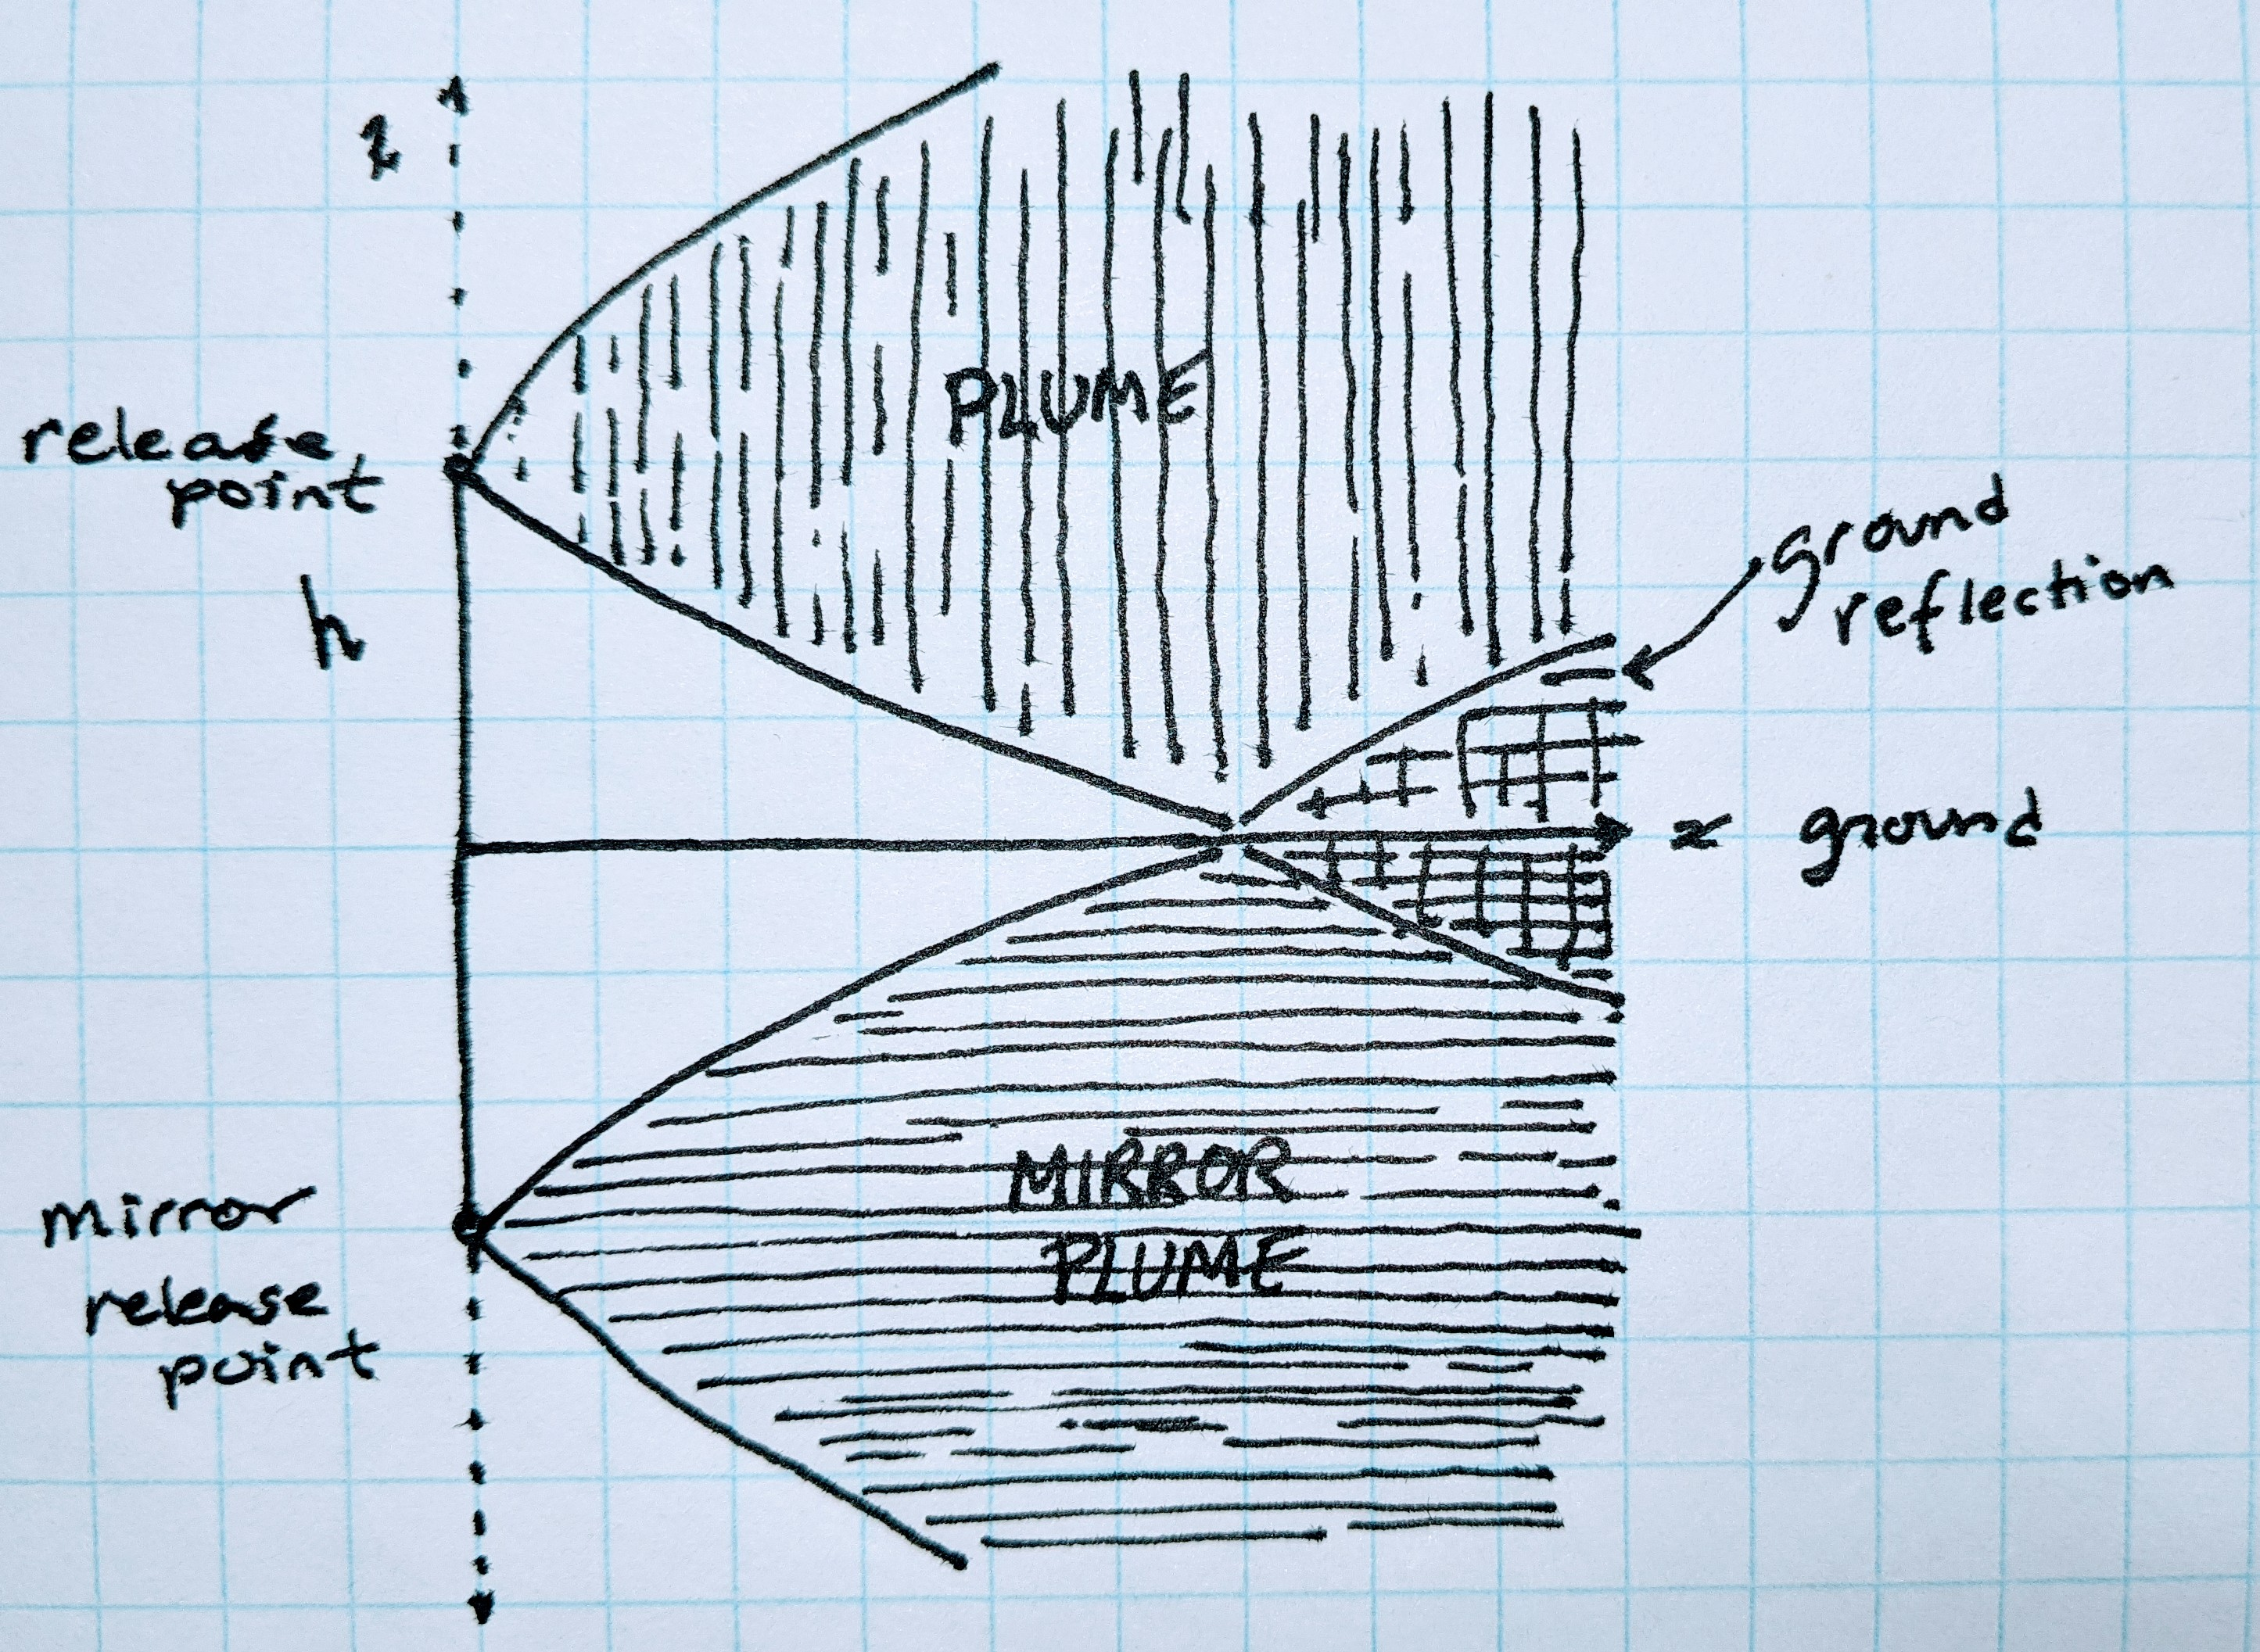

A sketch of ground reflection by method of images.
:::

One way to capture this is to integrate *z* from $-\infty$ to $\infty$ (recall that the release point is at the origin) and introduce a *mirror image* of the stack shifted *2h* below. The ground being the x-y plane at *z = -h*. By symmetry the portion of the mirror plume extending up above this plane is the same as the portion of the plume that, in this simple model, has extended below the ground. By adding the stack and the mirror stack together and shifting the z-coordinate so *z = 0* is the ground, ground reflection is captured and the expression for a release point at elevation *h* is given by

$$ C = {Q \over 2 \pi u \sigma_{y} \sigma_{z} } \exp \left[ -\frac{1}{2} \left( y \over \sigma_{y} \right)^2 \right] $$

$$ \times \left\{ \exp \left[ -\frac{1}{2} \left( { z -h } \over \sigma_{z} \right)^2 \right] + \exp \left[ -\frac{1}{2} \left( { z + h } \over \sigma_{z} \right)^2 \right] \right\} $$

## Pasquill-Gifford Model

The $\sigma_{y}$ and $\sigma_{z}$ are functions of the downwind distance *x*. In the derivation of the model they were assumed to be linear in *x* however in practice they are typically of the form:

$$ \sigma_{y} = a x^{b} $$

$$ \sigma_{z} = c x^{d} $$

With the constants tabulated based on the [Pasquill stability class criteria](https://en.wikipedia.org/wiki/Outline_of_air_pollution_dispersion#Characterization_of_atmospheric_turbulence). 

These particular correlations come from Lees[@lees-1996 page 15/113. There is a typo in the 4th edition of *Lees'* for the $\sigma_{z}$ corresponding to class F stability. For $x>500$ it is given as $$ \sigma_{z} = 10^{(1.91 - 1.37 \log(x) - 0.119 \log(x)^2)} $$ when it should be (note the signs) $$ \sigma_{z} = 10^{(-1.91 + 1.37 \log(x) - 0.119 \log(x)^2)} $$. I happen to have the paper version of the 2nd edition at home, which does not have the typo, whereas the standard version I use at work is the 4th edition on Knovel.] and are for a Pasquill stability class F


In [17]:
σy(x) = 0.067*x^0.90

function σz(x)
    if x < 500.0
        return 0.057*x^0.80
    else
        # Note: Lee's gives the commented out form but it is wrong
        # 10^(1.91 - 1.37*log10(x) - 0.119*log10(x)^2)
        return 10^(-1.91 + 1.37*log10(x) - 0.119*log10(x)^2)
    end
end;

These correlations are currently not unit-aware, so we can add that using a macro

In [18]:
# this macro adds a method to handle units
macro correl(f::Symbol, in_unit::Expr, out_unit::Expr)
    quote
        function $(esc(f))(x::Quantity)::Quantity
            x = ustrip($in_unit, x)
            res = $f(x)
            return res*$out_unit
        end
    end
end

@correl σy u"m" u"m"
@correl σz u"m" u"m"

σz (generic function with 2 methods)

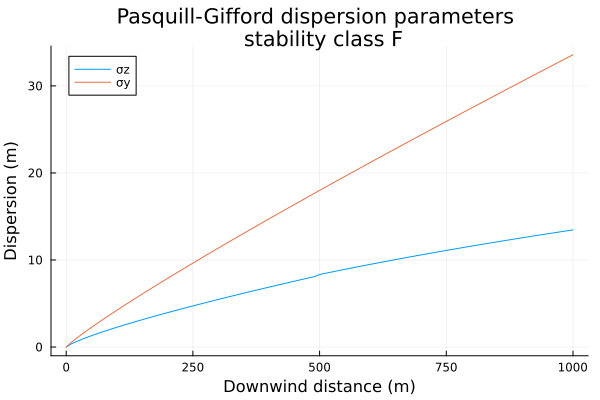

In [19]:
#| echo: false
#| label: fig-sigmas
#| fig-cap: "Pasquill-Gifford dispersion parameters as a function of downwind distance, for class F atmospheric stability."
let

xs = 0:10:1000
szs = σz.(xs)
sys = σy.(xs)

plot(xs, [szs sys], lab=["σz" "σy"], leg= :topleft, 
    title= "Pasquill-Gifford dispersion parameters \n stability class F",
    xlabel="Downwind distance (m)", ylabel="Dispersion (m)")

end

### Effect of Plume Rise

The effect of plume rise on this model is to shift from the actual stack height to an effective stack height $h_e = h_s + \Delta h$ with $\Delta h$ given by the plume rise model already discussed. Additionally the dispersion is adjusted by the following[@vallero-2014 pages 696-697]


$$ \sigma_{ze}^2 = \left( \Delta h \over 3.5 \right)^2 + \sigma_z^2 $$

$$ \sigma_{ye}^2 = \left( \Delta h \over 3.5 \right)^2 + \sigma_y^2 $$

and the final model of concentration is given in respect to the effective stack height

$$ C = {Q \over 2 \pi u \sigma_{ye} \sigma_{ze} } \exp \left[ -\frac{1}{2} \left( y \over \sigma_{ye} \right)^2 \right] $$

$$ \times \left\{ \exp \left[ -\frac{1}{2} \left( { z -h_e } \over \sigma_{ze} \right)^2 \right] + \exp \left[ -\frac{1}{2} \left( { z + h_e } \over \sigma_{ze} \right)^2 \right] \right\} $$

In [20]:
#| output: false
function C(x, y, z)
    hₑ  = hₛ + Δh(x)
    σyₑ = √( (Δh(x)/3.5)^2 + σy(x)^2 )
    σzₑ = √( (Δh(x)/3.5)^2 + σz(x)^2 )
    
    C = (Q/(2*π*uₛ*σyₑ*σzₑ)) *
         exp(-0.5*(y/σyₑ)^2) *
         ( exp(-0.5*((z-hₑ)/σzₑ)^2) + exp(-0.5*((z+hₑ)/σzₑ)^2) )
    
end

C (generic function with 1 method)

## Modelling Dispersion

There are two cases worth considering

1. without accounting for plume rise
1. with plume rise

The first case would be very conservative and the stack plume would immediately point directly downwind, at the stack height, this is far more likely to impact the work platform and any workers on the ground, though it is also quite unrealistic.

*Note* the following contour plots max out at the time weighted average concentration, shown in mg/m^3

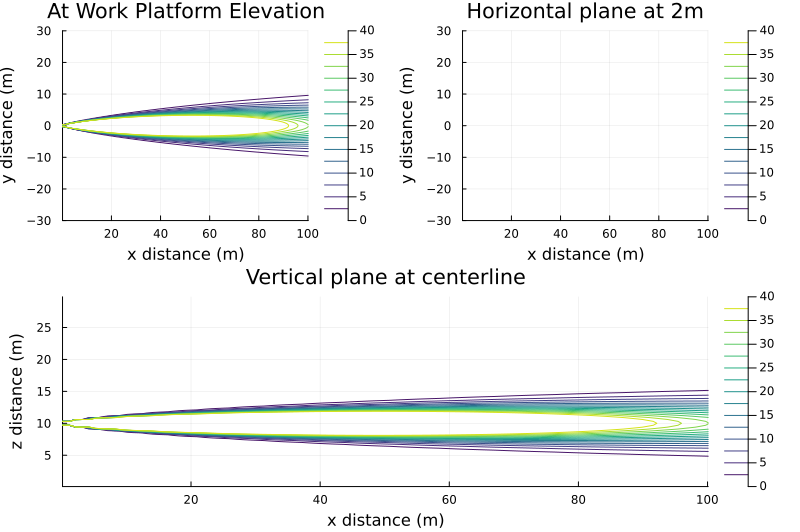

In [21]:
#| echo: false
#| label: fig-norise
#| fig-cap: "Contour plots of concentration with no plume rise."

let

function plt_C_norise(x, y, z)
    x  = x*u"m"
    y  = y*u"m"
    z  = z*u"m"
    hₑ = hₛ
    sy = σy(x)
    sz = σz(x)
    
    c = (Q/(2*π*uₛ*sy*sz)) *
         exp(-0.5*(y/sy)^2) *
         ( exp(-0.5*((z-hₑ)/sz)^2) + exp(-0.5*((z+hₑ)/sz)^2) )
        
    if isnan(c)
        return ustrip(Q/Vₛᵒ)*1e6
    else
        return ustrip(c)*1e6
    end
    
end


Cxy_norise(x, y) = plt_C_norise(x, y, ustrip(h₁))
Cxz_norise(x, z) = plt_C_norise(x, 0.0, z)

xs = 0.1:1:101
ys = -30:.3:30
zs = 0.1:.3:30

oel = ustrip(TWA)*1e6

# Plots.contour(xs, ys, C, c= :viridis, fill = true)
# heatmap(xs, ys, C, c= :viridis)

l = @layout [[a b]; c]
p1_nr = contour(xs, ys, (x,y) -> plt_C_norise(x, y, 2.0), c= :viridis, fill = false, clim=(0, oel),
        title="Horizontal plane at 2m", ylabel= "y distance (m)", xlabel="x distance (m)")
p2_nr = contour(xs, ys, Cxy_norise, c= :viridis, fill = false, clim=(0, oel),
        title="At Work Platform Elevation", ylabel= "y distance (m)", xlabel="x distance (m)")
p3_nr = contour(xs, zs, Cxz_norise, c= :viridis, fill = false, clim=(0,oel),
        title="Vertical plane at centerline", ylabel= "z distance (m)", xlabel="x distance (m)")
plot(p2_nr, p1_nr, p3_nr, layout = l, size=(800,533))

end

This clearly represents something of an extreme case, and I believe illustrates something of interest. While the work platform is ultimately below the TWA, to get even close to that concentration at the work platform the model is assuming extremely little mixing and no plume rise.

A more realistic model would take into account the buoyant rise of hot stack gases.

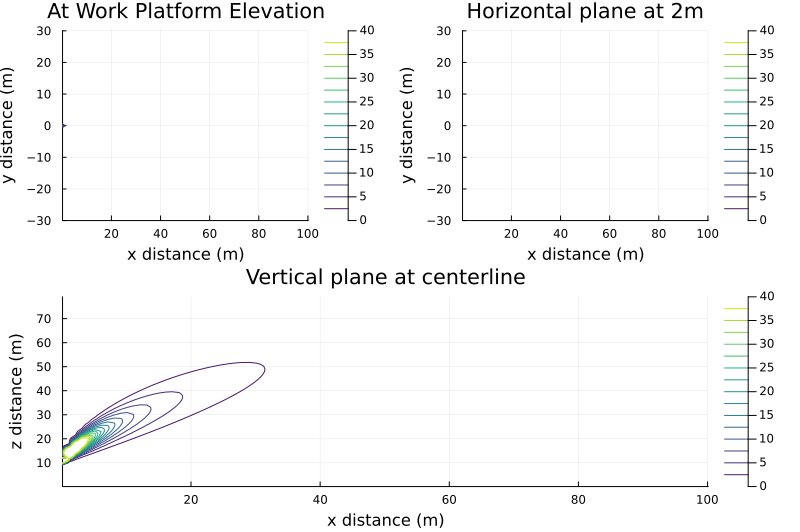

In [22]:
#| echo: false
#| label: fig-with-rise
#| fig-cap: "Contour plots of concentration with using Briggs' plume rise equations."
let

function plt_C(x, y, z)
    x = x*u"m"
    y = y*u"m"
    z = z*u"m"
    conc = C(x, y, z)
    
    if isnan(conc)
        return ustrip(Q/Vₛᵒ)*1e6
    else
        return ustrip(conc)*1e6
    end
    
end


Cxy(x, y) = plt_C(x, y, ustrip(h₁))
Cxz(x, z) = plt_C(x, 0.0, z)

xs = 0.1:1:101
ys = -30:.3:30
zs = 0.1:1:80

oel = ustrip(TWA)*1e6

# Plots.contour(xs, ys, C, c= :viridis, fill = true)
# heatmap(xs, ys, C, c= :viridis)

l = @layout [[a b]; c]
p1 = contour(xs, ys, (x,y) -> plt_C(x, y, 2.0), c= :viridis, fill = false, clim=(0, oel),
        title="Horizontal plane at 2m", ylabel= "y distance (m)", xlabel="x distance (m)")
p2 = contour(xs, ys, Cxy, c= :viridis, fill = false, clim=(0, oel),
        title="At Work Platform Elevation", ylabel= "y distance (m)", xlabel="x distance (m)")
p3 = contour(xs, zs, Cxz, c= :viridis, fill = false, clim=(0,oel),
        title="Vertical plane at centerline", ylabel= "z distance (m)", xlabel="x distance (m)")
plot(p2, p1, p3, layout = l, size=(800,533))

end

In this model the plume clearly rises significantly and, as it goes, mixes into the air column to such an extent that there is hardly any carbon monoxide at the elevations of interest downwind of the stack.

In [23]:
uconvert(u"mg/m^3",C(x₁, 0u"m", h₁))

0.0014282911474771348 mg m^-3

In [24]:
C(x₁, 0u"m", h₁) > TWA

false

## Concluding Remarks

This model assumed a continuous, steady-state, flow of stack gases. Boilers don't always operate that way and the model did not, for example, consider startup or upset conditions that could lead to higher in-stack concentrations of carbon monoxide.

The model also assumed mixing was captured by a simple Gaussian dispersion model. This model does not, for example, account for variability of wind speed either with time or spatially -- wind speed typically increases with height -- in this case I believe the model underestimates the degree of mixing. Nor does it account for interactions with buildings and potential down wash, which can be very significant.

This also assumes no other sources of carbon monoxide, both at the facility surrounding the worksite but also potentially from some portable equipment.

I think that, while modelling like this might be informative about the potential hazards, it is always good practise to develop a monitoring plan for the work area that includes the flue gases and any other potential substances to ensure workers on the scaffolding are not being exposed.


## References
::: {#refs}
:::
